In [1]:
import pickle

import sys
sys.path.append('..')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from data_loader.load_data import ImagesLoader

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report, \
                            confusion_matrix, \
                            ConfusionMatrixDisplay

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model

In [2]:
seed_number = 10
tf.random.set_seed(seed_number)
np.random.seed(seed_number)

import warnings
warnings.filterwarnings('ignore')

In [49]:
def plot_nn_history(history, figsize=(8,4)):
    fig, ax = plt.subplots(1,2, figsize=figsize)

    for i, field in enumerate(['acc', 'loss']):
        ax[i].plot(history.history[field])
        ax[i].plot(history.history[f'val_{field}'])
        ax[i].set_title(f'model {field}')
        ax[i].set_ylabel(field)
        ax[i].set_xlabel('epoch')
        ax[i].legend(['train', 'val'], loc='upper left')
    plt.show()

# **CARREGANDO OS DADOS**

In [3]:
DATASET_NAME = 'simpsons-small-balanced'
DATASET_NAME_TF = DATASET_NAME + '-tf'

batch_size_ = 32
input_shape_ = (315, 390, 3)
num_classes = 5

In [4]:
loader = ImagesLoader(train_images_path=f'../data/{DATASET_NAME}/train/',
                      test_images_path=f'../data/{DATASET_NAME}/test/')

with open(f'../data/{DATASET_NAME}/{DATASET_NAME}.pkl', 'rb') as infile:
    data = pickle.load(infile)

# **TRAIN-TEST SPLIT**

In [5]:
X_train = tf.keras.utils.image_dataset_from_directory(
    f'../data/{DATASET_NAME_TF}/train/',
    seed=seed_number,
    image_size=(input_shape_[0], input_shape_[1]),
    batch_size=batch_size_
)

X_test = tf.keras.utils.image_dataset_from_directory(
    f'../data/{DATASET_NAME_TF}/test/',
    seed=seed_number,
    image_size=(input_shape_[0], input_shape_[1]),
    batch_size=batch_size_
)

Found 324 files belonging to 5 classes.
Found 95 files belonging to 5 classes.


In [38]:
normalization_layer = layers.Rescaling(1./255)

X_train = X_train.map(lambda x, y: (normalization_layer(x), y))
X_test = X_test.map(lambda x, y: (normalization_layer(x), y))

In [29]:
# tensorflow.python.data.ops.dataset_ops.BatchDataset
# tensorflow.python.data.ops.dataset_ops.TakeDataset

np.array(list(X_train.as_numpy_iterator()))[0][0][0].shape

(315, 390, 3)

In [39]:
y_train = data['names_encoded']['train']
y_test = data['names_encoded']['test']

# **LENET**

In [40]:
def Lenet(input_shape=(32,32,1), n_classes=10):
    lenet = models.Sequential()

    lenet.add(layers.Conv2D(6, 5, activation='tanh', input_shape=input_shape))
    lenet.add(layers.AveragePooling2D(2))
    lenet.add(layers.Activation('sigmoid'))
    lenet.add(layers.Conv2D(16, 5, activation='tanh'))
    lenet.add(layers.AveragePooling2D(2))
    lenet.add(layers.Activation('sigmoid'))
    lenet.add(layers.Conv2D(120, 5, activation='tanh'))

    lenet.add(layers.Flatten())
    lenet.add(layers.Dense(84, activation='tanh'))
    lenet.add(layers.Dense(n_classes, activation='softmax'))

    return lenet  

lenet = Lenet(input_shape=(315, 390, 3), n_classes=5)
lenet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 311, 386, 6)       456       
                                                                 
 average_pooling2d_6 (Averag  (None, 155, 193, 6)      0         
 ePooling2D)                                                     
                                                                 
 activation_6 (Activation)   (None, 155, 193, 6)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 151, 189, 16)      2416      
                                                                 
 average_pooling2d_7 (Averag  (None, 75, 94, 16)       0         
 ePooling2D)                                                     
                                                                 
 activation_7 (Activation)   (None, 75, 94, 16)       

In [41]:
epochs_ = 20

lenet.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = lenet.fit(
    X_train,
    batch_size=batch_size_,
    epochs=epochs_,
    validation_data=X_test
)

Epoch 1/20
11/11 [==============================] - 34s 3s/step - loss: 3.4052 - acc: 0.2160 - val_loss: 3.3126 - val_acc: 0.2632
Epoch 2/20
11/11 [==============================] - 32s 3s/step - loss: 2.8111 - acc: 0.2469 - val_loss: 2.9030 - val_acc: 0.2632
Epoch 3/20
11/11 [==============================] - 32s 3s/step - loss: 2.5205 - acc: 0.2593 - val_loss: 2.7457 - val_acc: 0.3684
Epoch 4/20
11/11 [==============================] - 33s 3s/step - loss: 2.3538 - acc: 0.2469 - val_loss: 2.6798 - val_acc: 0.2632
Epoch 5/20
11/11 [==============================] - 33s 3s/step - loss: 2.2758 - acc: 0.2284 - val_loss: 2.5681 - val_acc: 0.2632
Epoch 6/20
11/11 [==============================] - 35s 3s/step - loss: 2.1885 - acc: 0.2469 - val_loss: 2.4152 - val_acc: 0.2632
Epoch 7/20
11/11 [==============================] - 34s 3s/step - loss: 2.0961 - acc: 0.2469 - val_loss: 2.2989 - val_acc: 0.3684
Epoch 8/20
11/11 [==============================] - 33s 3s/step - loss: 2.0139 - acc: 0.25

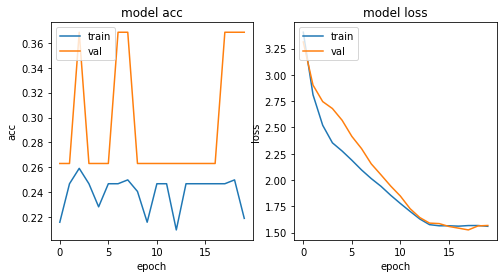

In [50]:
plot_nn_history(history)

3/3 [==============================] - 2s 586ms/step
              precision    recall  f1-score   support

           0       0.37      1.00      0.54        35
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        12

    accuracy                           0.37        95
   macro avg       0.07      0.20      0.11        95
weighted avg       0.14      0.37      0.20        95



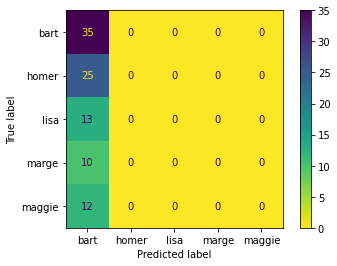

In [51]:
y_pred = lenet.predict(X_test)
y_pred = np.array([np.argmax(i) for i in y_pred])

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
cm_plot.plot(cmap='viridis_r');

# **ALEXNET**

In [72]:
def Alexnet(shape=(224,224,3), n_classes=10):
    input_img = layers.Input(shape=shape)

    model = layers.Conv2D(
        filters=96,
        kernel_size=(11,11),
        strides=(4,4),
        activation='relu'
    )(input_img)

    model = layers.BatchNormalization()(model)
    model = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(model)

    model = layers.Conv2D(
        filters=256,
        kernel_size=(5,5),
        strides=(1,1),
        activation='relu',
        padding='same'
    )(model)
    
    model = layers.BatchNormalization()(model)
    model = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(model)
    
    model = layers.Conv2D(
        filters=384,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
        padding='same'
    )(model)
    
    model = layers.BatchNormalization()(model)
    
    model = layers.Conv2D(
        filters=384,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
        padding='same'
    )(model)
    
    model = layers.BatchNormalization()(model)

    model = layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
        padding='same'
    )(model)
    
    model = layers.BatchNormalization()(model)
    model = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(model)
    
    model = layers.Flatten()(model)
    model = layers.Dense(4096, activation='relu')(model)
    model = layers.Dropout(0.5)(model)
    model = layers.Dense(4096, activation='relu')(model)
    model = layers.Dropout(0.5)(model)
    model = layers.Dense(n_classes, activation='softmax')(model)
    model = Model(inputs=[input_img], outputs=[model])
    
    return model

alexnet = Alexnet()
alexnet.summary()

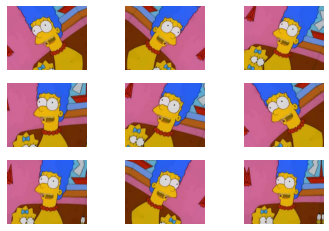

In [73]:
for images, _ in X_train.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [76]:
model = tf.keras.Sequential([
    data_augmentation,  
    layers.Rescaling(1./255, input_shape=(96, 96, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),  
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [77]:
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    X_train,
    batch_size=batch_size_,
    epochs=epochs_,
    validation_data=X_test
)

Epoch 1/20
11/11 [==============================] - 57s 5s/step - loss: 8.5030 - acc: 0.3086 - val_loss: 1.5672 - val_acc: 0.3684
Epoch 2/20
11/11 [==============================] - 55s 5s/step - loss: 1.4637 - acc: 0.3827 - val_loss: 1.4354 - val_acc: 0.4105
Epoch 3/20
11/11 [==============================] - 57s 5s/step - loss: 1.2737 - acc: 0.4691 - val_loss: 2.3291 - val_acc: 0.2526
Epoch 4/20
11/11 [==============================] - 55s 5s/step - loss: 1.2052 - acc: 0.5370 - val_loss: 1.1586 - val_acc: 0.4632
Epoch 5/20
11/11 [==============================] - 45s 4s/step - loss: 0.9421 - acc: 0.5741 - val_loss: 1.0831 - val_acc: 0.4737
Epoch 6/20
11/11 [==============================] - 47s 4s/step - loss: 0.8976 - acc: 0.6451 - val_loss: 1.0969 - val_acc: 0.4632
Epoch 7/20
11/11 [==============================] - 42s 4s/step - loss: 0.8045 - acc: 0.6543 - val_loss: 1.0675 - val_acc: 0.4737
Epoch 8/20
11/11 [==============================] - 46s 4s/step - loss: 0.6934 - acc: 0.71

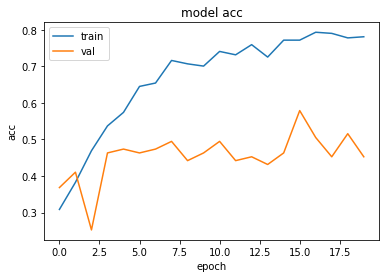

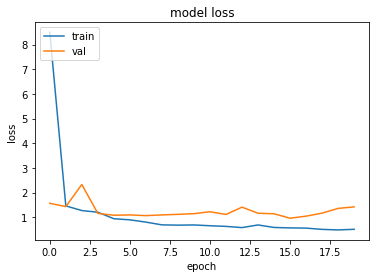

In [78]:
plot_history(history)

3/3 [==============================] - 2s 783ms/step
              precision    recall  f1-score   support

           0       0.41      0.20      0.27        35
           1       0.23      0.44      0.30        25
           2       0.00      0.00      0.00        13
           3       0.17      0.10      0.12        10
           4       0.14      0.17      0.15        12

    accuracy                           0.22        95
   macro avg       0.19      0.18      0.17        95
weighted avg       0.25      0.22      0.21        95



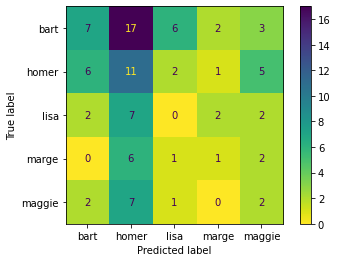

In [79]:
y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(i) for i in y_pred])

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
cm_plot.plot(cmap='viridis_r');

# **VGG16**

In [10]:
conv_layers =  tf.keras.applications.resnet50.ResNet50(
    weights=None,
    include_top=False,
    input_tensor=tf.keras.layers.Input(input_shape_),
    classes=num_classes
)

conv_layers.trainable = True

model = tf.keras.Sequential([  
  conv_layers,    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 10, 13, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 266240)            0         
                                                                 
 dense (Dense)               (None, 128)               34078848  
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 57,667,205
Trainable params: 57,614,085
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
epochs_ = 10

model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

history = model.fit(
    X_train,
    batch_size=batch_size_,
    epochs=epochs_,
    validation_data=X_test)

Epoch 1/10
11/11 [==============================] - 370s 30s/step - loss: 140.6774 - acc: 0.2160 - val_loss: 81374.1406 - val_acc: 0.2842
Epoch 2/10
11/11 [==============================] - 292s 27s/step - loss: 18.4143 - acc: 0.2840 - val_loss: 93500608.0000 - val_acc: 0.2632
Epoch 3/10
11/11 [==============================] - 290s 26s/step - loss: 9.5449 - acc: 0.2377 - val_loss: 28768186.0000 - val_acc: 0.3684
Epoch 4/10
11/11 [==============================] - 304s 28s/step - loss: 4.7650 - acc: 0.2932 - val_loss: 3208833.2500 - val_acc: 0.2737
Epoch 5/10
11/11 [==============================] - 288s 26s/step - loss: 4.0849 - acc: 0.2994 - val_loss: 680874.6875 - val_acc: 0.3684
Epoch 6/10
11/11 [==============================] - 273s 25s/step - loss: 2.9889 - acc: 0.2809 - val_loss: 24056.6523 - val_acc: 0.3684
Epoch 7/10
11/11 [==============================] - 302s 27s/step - loss: 3.8182 - acc: 0.2562 - val_loss: 24100.8848 - val_acc: 0.3684
Epoch 8/10
11/11 [==================

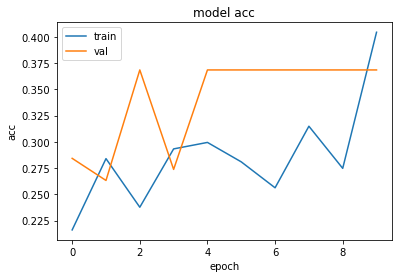

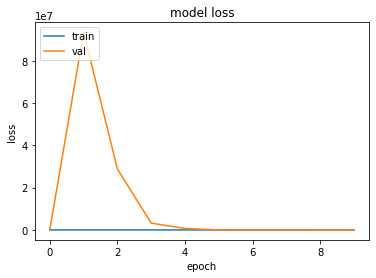

In [14]:
plot_history(history)

3/3 [==============================] - 26s 8s/step
              precision    recall  f1-score   support

           0       0.37      1.00      0.54        35
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        12

    accuracy                           0.37        95
   macro avg       0.07      0.20      0.11        95
weighted avg       0.14      0.37      0.20        95



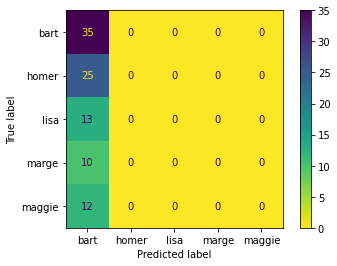

In [15]:
y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(i) for i in y_pred])

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=loader.labels)
cm_plot.plot(cmap='viridis_r');